In [283]:
import Data_generator_multipal as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
import matplotlib.pyplot as plt
import UtilityLoss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [314]:
# initialize seed, mu, sigma, S0, paths, steps, T
seed = 62
num = 2
npaths = 1000
seq_length = 120
T=1
s0=np.array([8,8])
mu = np.array([0.2, 0.4])
cov = np.array([[0.25, 0],[0, 0.25]])


In [315]:
# Create a stock simulation with prices, returns
stock = dg.ManyStocks(seed,num,mu,s0,cov,npaths,seq_length-1,T)
prices = torch.tensor(stock.Prices(),dtype=torch.float).to(device)
returns = torch.tensor(stock.Returns(),dtype=torch.float).to(device)
# Create a default strategy as initial input, better use the optimal strategy without cost
strategy = 0.5*torch.ones((num,seq_length,npaths),dtype=torch.float).to(device)
# Create a trading cost
cost =  torch.tensor(0.05*np.ones([num,seq_length-1,npaths]),dtype=torch.double).to(device)

In [316]:
def cal_return(strat):   
    r1 = strat[:,:-1, :]*returns-torch.sum(cost*abs((strat[:,:-1, :]*returns+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r2 = strat[:,:-1, :]*returns-torch.sum(cost*abs((r1+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r3 = strat[:,:-1, :]*returns-torch.sum(cost*abs((r2+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r4 = strat[:,:-1, :]*returns-torch.sum(cost*abs((r3+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    r5 = strat[:,:-1, :]*returns-torch.sum(cost*abs((r4+1)*strat[:,1:, :]-(returns+1)*strat[:,:-1, :]),axis=0)
    return r5

class Cal_return(nn.Module):
    def __init__(self):
        
        super().__init__()

    def forward(self, strat):

        return cal_return(strat) 

In [317]:
class LogUtilityLoss(torch.nn.Module):
    
    def __init__(self):
        super(LogUtilityLoss,self).__init__()
        
    def forward(self,x):
        loss = -torch.mean(torch.log(x))
        return loss

In [318]:
class PowerUtilityLoss(torch.nn.Module):
    
    def __init__(self,gamma):
        super(PowerUtilityLoss,self).__init__()
        self.gamma = gamma
        
    def forward(self,x):
        loss = -torch.mean((torch.pow(x,1-self.gamma)-1)/(1-self.gamma))
        return loss

In [331]:
# Customize a RNN layer with double relu
# considering returns data to build a changed strategy weight according to price change
class MyRNN(nn.Module):

    def __init__(self, input_size, hidden_size, batch_size,dim_size):
        """Initialize params."""
        super(MyRNN, self).__init__()
        # read input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.dim_size = dim_size

        self.input_param = nn.Linear(input_size, dim_size,  hidden_size).to(device)
        self.hidden_param = nn.Linear(hidden_size,  dim_size, hidden_size).to(device)
        self.fc1_param = nn.Linear(hidden_size, dim_size,hidden_size).to(device)
        self.fc2_param = nn.Linear(hidden_size, dim_size, hidden_size).to(device)
        
    # Forward function allows a form:
    # h_t = w_fc2*relu(w_fc1*relu(w_inp*x_t+b_inp+w_h*h_{t-1}+b_h)+b_fc1)+b_fc2+b_fc1-b_h1
    def forward(self, input, hidden):
        """Propogate input through the network."""
        
        def recurrence(input, hidden):
            """Recurrence helper."""
            
            ingate = self.input_param.weight*input + self.hidden_param.weight*hidden+self.hidden_param.bias.view(self.dim_size,self.hidden_size)
            ingate2 = self.fc1_param.weight*F.relu(ingate)+self.fc1_param.bias.view(self.dim_size,self.hidden_size)
            h = self.fc2_param.weight*F.relu(ingate2)+\
                self.fc1_param.bias.view(self.dim_size,self.hidden_size)-self.hidden_param.bias.view(self.dim_size,self.hidden_size)
            return h


        # Loop to formulate the rnn
        output = []
        steps = range(input.size(1))
        myret = returns
        for i in steps:
            if i ==0:
                hidden = input[:,0,:].to(device)
            else:
            # pi_t = pi_{t-1}*(1+r_t)/(1+sum(pi_{t-1}*r_t)) due to change of price after rebalance
                hidden = recurrence(input[:,i,:], hidden*(1+myret[:,i-1,:])/(1+torch.sum(hidden*myret[:,i-1,:],0)))
            output.append(hidden.view(self.dim_size, 1, self.batch_size))

        output = torch.cat(output, 1)

        return output, hidden

In [332]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, batch_size, seq_length, dim_size):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.batch_size = batch_size
        self.seq_length = seq_length
        self.dim_size = dim_size
        # the rnn layer which works as out, hidden_t = f(out_(t), hidden_(t-1)), used to approximate pi^*_(t)= f(pi^*_(t-1),pi_t)
        self.rnn = MyRNN(input_size, hidden_size, batch_size, dim_size).to(device)
        self.out = nn.Linear(dim_size, hidden_size,bias=False).to(device)
        # initialize some bias and weight
        self.rnn.input_param.weight = torch.nn.Parameter(torch.zeros_like(self.rnn.input_param.weight))
        self.rnn.hidden_param.weight = torch.nn.Parameter(torch.ones_like(self.rnn.hidden_param.weight))
        self.rnn.hidden_param.bias = torch.nn.Parameter(-0.76*torch.ones_like(self.rnn.hidden_param.bias))
        self.rnn.fc1_param.bias = torch.nn.Parameter(0.08*torch.ones_like(self.rnn.fc1_param.bias))
        self.rnn.fc1_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc1_param.weight))
        self.rnn.fc2_param.weight = torch.nn.Parameter(-1*torch.ones_like(self.rnn.fc2_param.weight))
        self.out.weight = torch.nn.Parameter(*torch.ones_like(self.out.weight))

    def step(self, input, hidden=None):
        output, hidden = self.rnn(input, hidden).to(device)
        output2 = self.out.weight.view(dim_size,hidden_size,hidden_size)*output
        return output, output2

    def forward(self, inputs, hidden=None):
        hidden = self.__init__hidden().to(device)
        output, hidden = self.rnn(inputs.float(), hidden.float())
        # output2 the overall wealth at time T
        output2 = torch.sum(torch.prod(cal_return(output.float()).to(device)+1,1),0)
        return  output, output2
        #return  output

    def __init__hidden(self):
        hidden = 0.0*torch.ones(self.dim_size, self.hidden_size,  self.batch_size,dtype=torch.float64).to(device)
        return hidden

In [333]:
# Set up model parameters, using paths as bath size, might not be the best, will try to fix later
n_epochs = 200
input_size = 1
hidden_size = 1
n_layers = 1
batch_size = 1000
seq_length = 120
dim_size = 2

model = SimpleRNN(input_size, hidden_size, n_layers, batch_size, seq_length,dim_size).to(device)
#criterion = LogUtilityLoss()
criterion = PowerUtilityLoss(2)
#model.rnn.bias_ih_l0.requires_grad = False
#model.rnn.bias_ih_l1.requires_grad = False
#model.rnn.weight_hh_l0.requires_grad = False
model.out.weight.requires_grad = False
model.rnn.input_param.weight.requires_grad = False
model.rnn.hidden_param.weight.requires_grad = False
model.rnn.fc1_param.weight.requires_grad = False
model.rnn.fc2_param.weight.requires_grad = False
#model.rnn.fc2_param.bias.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)

In [334]:
# Loss for plotting
losses = np.zeros(n_epochs) 

for epoch in range(n_epochs):
    inputs = strategy.to(device)
    fina_strat, outputs = model(inputs.double(), None)

    loss = criterion(outputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses[epoch] += loss
    if epoch % 10 == 0:
        print(epoch, loss)

0 tensor(-0.5245, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
10 tensor(-0.5359, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
20 tensor(-0.5385, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
30 tensor(-0.5456, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
40 tensor(-0.5553, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
50 tensor(-0.5562, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
60 tensor(-0.5563, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
70 tensor(-0.5570, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
80 tensor(-0.5569, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
90 tensor(-0.5571, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
100 tensor(-0.5570, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
110 tensor(-0.5571, device='cuda:0', dtype=torch.float64, grad_fn=<NegBackward>)
120 tensor(-0.5571, device='cuda:0', dt

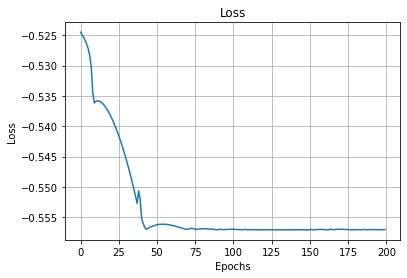

In [323]:
# Plot loss curve
epochs = range(n_epochs)

fig, ax = plt.subplots()
ax.plot(epochs, losses)

ax.set(xlabel='Epochs', ylabel='Loss',
       title='Loss')
ax.grid()

plt.show()

In [325]:
fina_strat[1]

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [1.0049, 1.0049, 1.0049,  ..., 1.0049, 1.0049, 1.0049],
        [1.0049, 1.0049, 1.0049,  ..., 1.0049, 1.0049, 1.0049],
        ...,
        [1.0049, 1.0049, 1.0049,  ..., 1.0049, 1.0049, 1.0049],
        [1.0049, 1.0049, 1.0049,  ..., 1.0049, 1.0049, 1.0049],
        [1.0049, 1.0049, 1.0049,  ..., 1.0049, 1.0049, 1.0049]],
       device='cuda:0', grad_fn=<SelectBackward>)

In [326]:
for name, param in model.named_parameters():
    print (name, param.data)

rnn.input_param.weight tensor([[0.],
        [0.]], device='cuda:0')
rnn.input_param.bias tensor([0.9817, 0.6010], device='cuda:0')
rnn.hidden_param.weight tensor([[1.],
        [1.]], device='cuda:0')
rnn.hidden_param.bias tensor([-1.0478, -1.0548], device='cuda:0')
rnn.fc1_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc1_param.bias tensor([-0.0486, -0.0496], device='cuda:0')
rnn.fc2_param.weight tensor([[-1.],
        [-1.]], device='cuda:0')
rnn.fc2_param.bias tensor([-0.2005, -0.9730], device='cuda:0')
out.weight tensor([1., 1.], device='cuda:0')


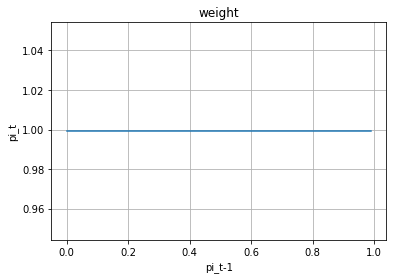

In [330]:
# Data for plotting
t = torch.tensor(np.arange(0, 1, 0.01)).to(device)
s = model.rnn.fc2_param.weight[0]*F.relu(model.rnn.fc1_param.weight[0]*F.relu(0.8*model.rnn.input_param.weight[0]+model.rnn.hidden_param.weight[0]*t+model.rnn.hidden_param.bias[0])+model.rnn.fc1_param.bias[0])+model.rnn.fc1_param.bias[0]-model.rnn.hidden_param.bias[0]

fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach())

ax.set(xlabel='pi_t-1', ylabel='pi_t',
       title='weight')
ax.grid()

fig.savefig("test.png")
plt.show()

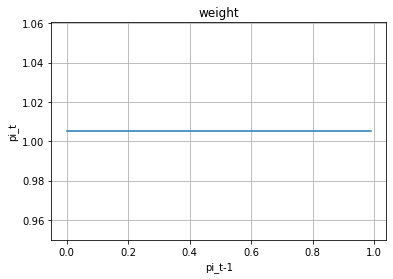

In [328]:
# Data for plotting
t = torch.tensor(np.arange(0, 1, 0.01)).to(device)
s = model.rnn.fc2_param.weight[1]*F.relu(model.rnn.fc1_param.weight[1]*F.relu(0.8*model.rnn.input_param.weight[1]+model.rnn.hidden_param.weight[1]*t+model.rnn.hidden_param.bias[1])+model.rnn.fc1_param.bias[1])+model.rnn.fc1_param.bias[1]-model.rnn.hidden_param.bias[1]

fig, ax = plt.subplots()
ax.plot(t.cpu().detach(), s.cpu().view(-1).detach())

ax.set(xlabel='pi_t-1', ylabel='pi_t',
       title='weight')
ax.grid()

fig.savefig("test.png")
plt.show()